#**A. Pre-Requisites**

In [ ]:
%%capture

# 1. Kaggle Installation
!pip install kaggle

# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Download Kaggele data directly into Google Colab
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/COMP700/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# **B. Install the Required Libraries**

In [ ]:
%%capture

# SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Transformers
!pip install -q git+https://github.com/huggingface/transformers.git

# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai

# Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install nibabel

# **1. Retina Blood Vessel Dataset**

## Download Dataset

In [ ]:
!kaggle datasets download abdallahwagih/retina-blood-vessel
!unzip -q retina-blood-vessel.zip

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel
License(s): apache-2.0
 97% 32.0M/32.9M [00:00<00:00, 89.0MB/s]
100% 32.9M/32.9M [00:00<00:00, 74.9MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Data/test/image'  # Directory with image .png files
mask_dir = '/content/Data/test/mask'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 20 images of shape (256, 256) (HxW)
Loaded 20 masks of shape (256, 256) (HxW)
Image shape: (20, 256, 256)
Mask shape: (20, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 20
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/retina_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/retina_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 20
})

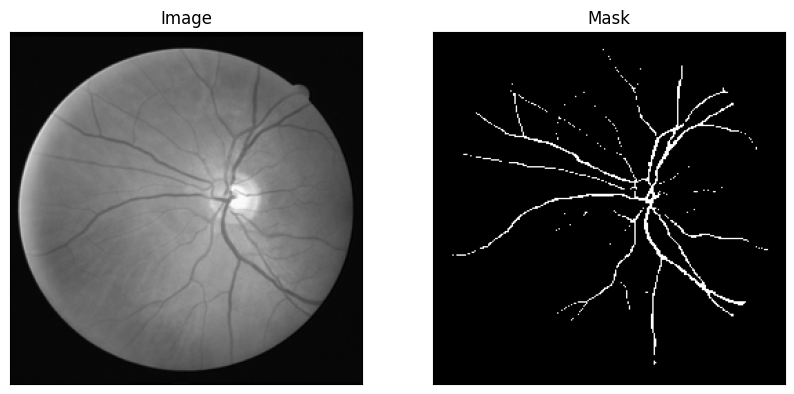

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **2. Hi-gMISnet_all Dataset (Medical Image Segmentation Datasets)**
Hi-gMISnet_all_dataset contains:


1.   BUSI (**B**reast **U**ltra**S**ound **I**mages)
2.   CVC_CLINIC_DB (CVC Clinic Database for colonoscopy video analysis)
3.   GLAS (**Gla**nd **S**egmentation - in Colon Histology Images)
4.   ISIC_2018 (**I**nternal **S**kin **I**maging **C**ollaboration 2018)
5.   MoNuSeg (**M**ulti-**O**rgan **Nu**clei **S**egmentation)
6.   Montgomery_County (Montgomery County X-ray Set - for TB Detection)
7.   PROMISE12 (**Pro**state **M**R **I**mage **Se**gmentation)
8.   Physionet_ICH (Physionet **I**ntra**C**ranial **H**emorrhage)



## Download Dataset

In [ ]:
!kaggle datasets download tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
!unzip -q medical-image-segmentation-datasets-hi-gmisnet.zip

Dataset URL: https://www.kaggle.com/datasets/tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
License(s): MIT
100% 1.70G/1.70G [00:27<00:00, 101MB/s] 
100% 1.70G/1.70G [00:27<00:00, 67.4MB/s]


## **2.1. Physionet_ICH Dataset**

### Create the Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/Physionet_ICH/test/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/Physionet_ICH/test/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 32 images of shape (256, 256) (HxW)
Loaded 32 masks of shape (256, 256) (HxW)
Image shape: (32, 256, 256)
Mask shape: (32, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 32
})

### Save the Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/physionet_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/physionet_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 32
})

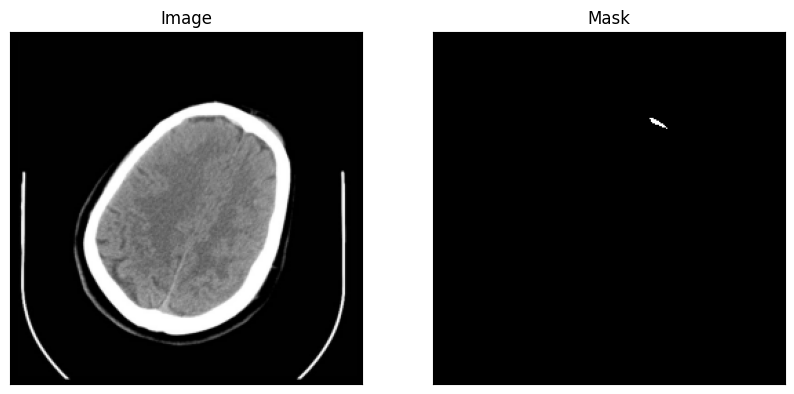

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.2. MoNuSeg Dataset**

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/MoNuSeg/test folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/MoNuSeg/test folder/labelcol'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 14 images of shape (256, 256) (HxW)
Loaded 14 masks of shape (256, 256) (HxW)
Image shape: (14, 256, 256)
Mask shape: (14, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 14
})

### Save Dataset to Drive

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/monuseg_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the created dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/monuseg_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 14
})

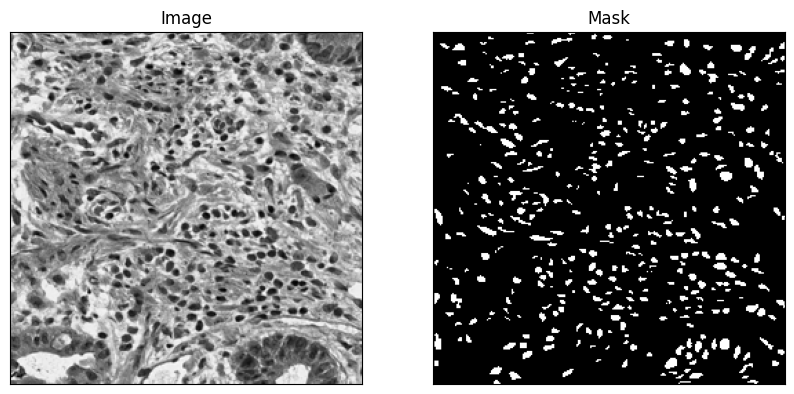

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.3. BUSI Dataset**

### Create Dataset from BUSI

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/BUSI/test_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/BUSI/test_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 65 images of shape (256, 256) (HxW)
Loaded 65 masks of shape (256, 256) (HxW)
Image shape: (65, 256, 256)
Mask shape: (65, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 65
})

Save the dataset into Drive

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/busi_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the BUSI Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/busi_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 65
})

Make sure the dataset is working properly after loading from drive

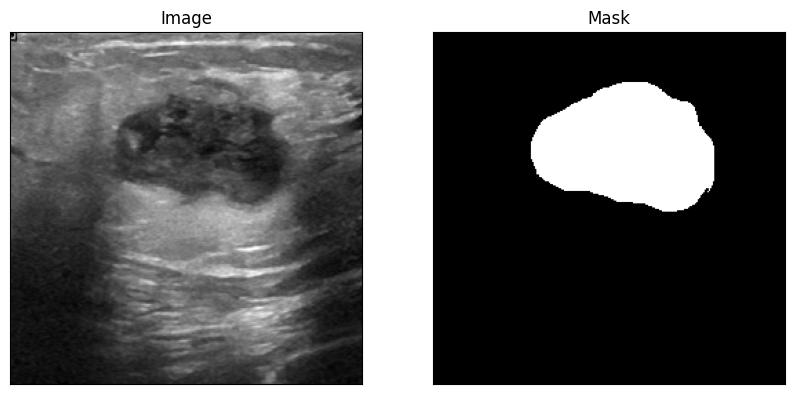

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.4. CVC_Clinic_DB**

### Create Dataset from CVC_CLINIC_DB

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/CVC_clinic_DB/test/test folder/img'  # Directory with image .jpg files
mask_dir = '/content/Hi-gMISnet_all_dataset/CVC_clinic_DB/test/test folder/label'    # Directory with mask .jpg files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 61 images of shape (256, 256) (HxW)
Loaded 61 masks of shape (256, 256) (HxW)
Image shape: (61, 256, 256)
Mask shape: (61, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 61
})

Save the created dataset into the drive

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/cvc_clinic_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the CVC_Clinic Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/cvc_clinic_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 61
})

Make sure the dataset loads images and masks properly

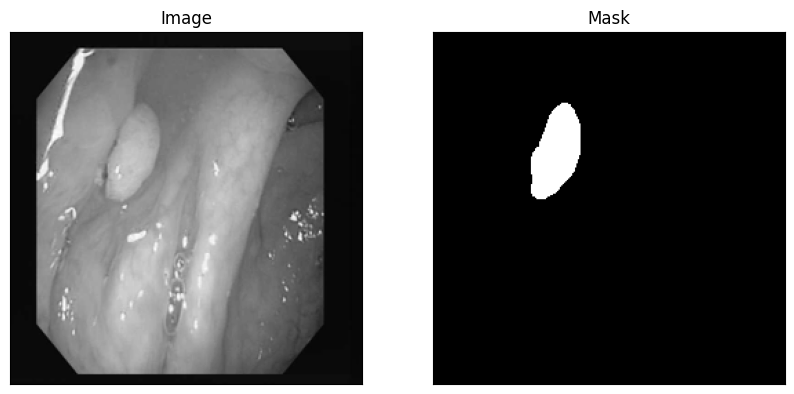

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.5. PROMISE12 Dataset**

Prostate MRI Segmentation

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/PROMISE12/test_data/image'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/PROMISE12/test_data/mask'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 418 images of shape (256, 256) (HxW)
Loaded 418 masks of shape (256, 256) (HxW)
Image shape: (418, 256, 256)
Mask shape: (418, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 418
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/promise_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/promise_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 418
})

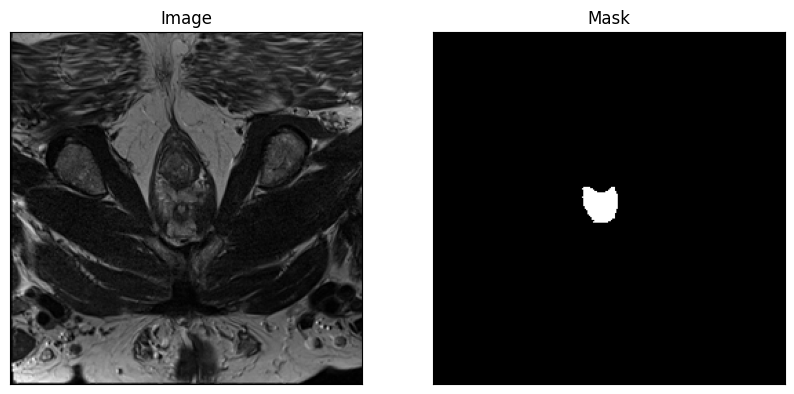

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.6. ISIC2018 Dataset**

Internal Skin Imaging Collaboration

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/ISIC_2018/test_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/ISIC_2018/test_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 260 images of shape (256, 256) (HxW)
Loaded 260 masks of shape (256, 256) (HxW)
Image shape: (260, 256, 256)
Mask shape: (260, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 260
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/isic_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/isic_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 260
})

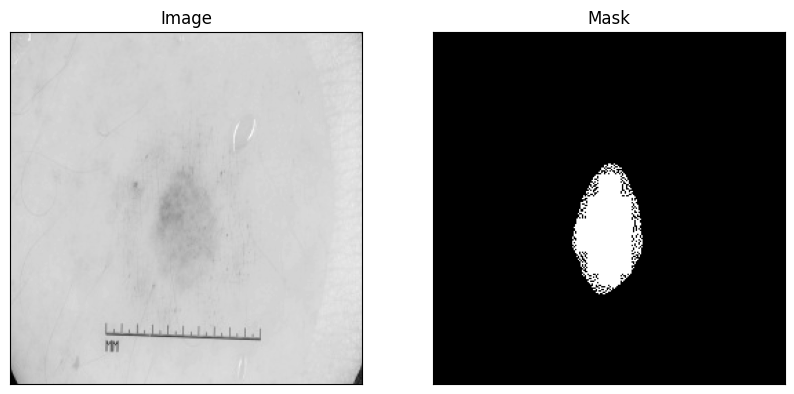

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.7. Montgomery County Dataset**

Chest X-Ray

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/Montgomery_County/test_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/Montgomery_County/test_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 14 images of shape (256, 256) (HxW)
Loaded 14 masks of shape (256, 256) (HxW)
Image shape: (14, 256, 256)
Mask shape: (14, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 14
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/montgomery_chest_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/montgomery_chest_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 14
})

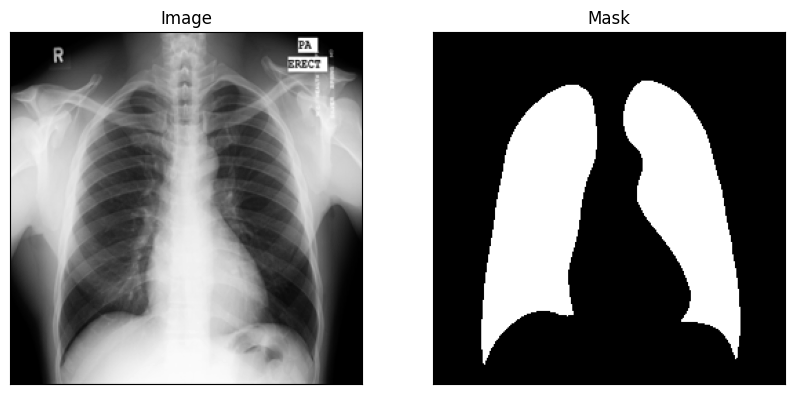

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **3. Liver Segmentation Dataset**

### Download Dataset

In [ ]:
!kaggle datasets download zxcv2022/digital-medical-images-for--download-resource
!unzip -q digital-medical-images-for--download-resource.zip

Dataset URL: https://www.kaggle.com/datasets/zxcv2022/digital-medical-images-for--download-resource
License(s): unknown
 36% 6.00M/16.8M [00:00<00:00, 61.9MB/s]
100% 16.8M/16.8M [00:00<00:00, 124MB/s] 


### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define the path to the directory containing both images and masks
data_dir = '/content/div-images/test'  # Directory containing both images and masks

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images and masks from a folder
def load_images_and_masks(folder, target_size):
    images = []
    masks = []

    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            # Check if the file is an image
            if not filename.endswith('_mask.png'):
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(target_size)  # Resize to the target size
                img_np = np.array(img)
                images.append(img_np)

                # Load corresponding mask
                mask_filename = filename.replace('.png', '_mask.png')  # Create mask filename
                mask_path = os.path.join(folder, mask_filename)

                if os.path.exists(mask_path):  # Ensure the mask file exists
                    mask = Image.open(mask_path).convert('L')
                    mask = mask.resize(target_size)  # Resize to the target size
                    mask_np = np.array(mask)
                    masks.append(mask_np)

    return np.array(images), np.array(masks)

# Load and resize images and masks
large_images, large_masks = load_images_and_masks(data_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 16 images of shape (256, 256) (HxW)
Loaded 16 masks of shape (256, 256) (HxW)
Image shape: (16, 256, 256)
Mask shape: (16, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 16
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/liverseg_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/liverseg_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 16
})

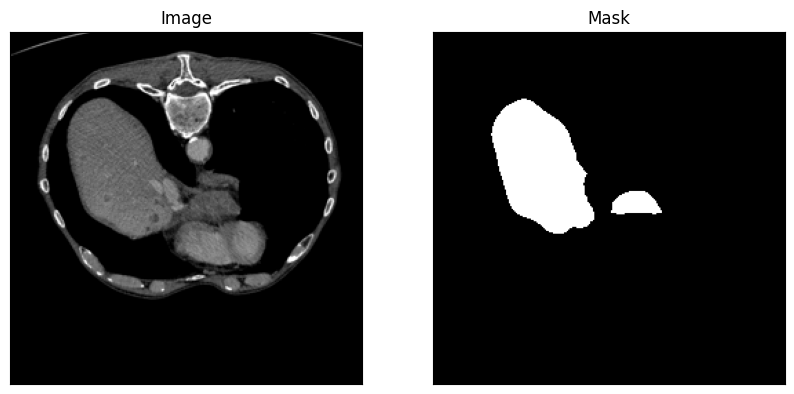

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **4. REFUGE Dataset**

## Download Dataset

In [ ]:
!kaggle datasets download arnavjain1/glaucoma-datasets
!unzip -q glaucoma-datasets.zip

Dataset URL: https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 5.54G/5.55G [01:18<00:00, 81.7MB/s]
100% 5.55G/5.55G [01:18<00:00, 76.1MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing images and masks
image_dir = '/content/REFUGE/test/Images'  # Directory with image .png or .jpg files
mask_dir = '/content/REFUGE/test/gts'  # Directory with mask .bmp files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size, file_extensions=('.png', '.jpg', '.bmp')):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.lower().endswith(file_extensions):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)  # Load images (.png/.jpg)
large_masks = load_images_from_folder(mask_dir, resize_to, file_extensions=('.bmp',))  # Load masks (.bmp)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 400 images of shape (256, 256) (HxW)
Loaded 400 masks of shape (256, 256) (HxW)
Image shape: (400, 256, 256)
Mask shape: (400, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/refuge_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/refuge_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

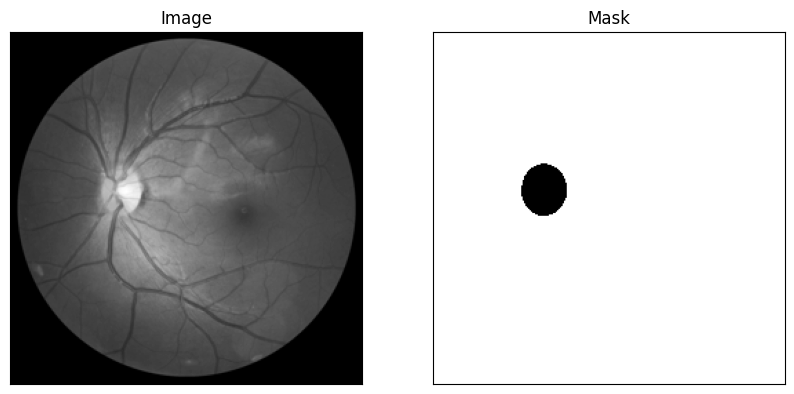

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **5. Abdominal Organ Segmentation Dataset**

## Download Dataset

In [ ]:
!kaggle datasets download monirulhaquebracu/abdominal-organ-segmentation-dataset
!unzip -q abdominal-organ-segmentation-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/monirulhaquebracu/abdominal-organ-segmentation-dataset
License(s): CC-BY-SA-4.0
100% 1.90G/1.90G [00:20<00:00, 114MB/s]
100% 1.90G/1.90G [00:20<00:00, 98.3MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define path to the main training directory containing subfolders with images and masks
train_dir = '/content/split_organized/test'  # Parent directory with image and mask folders

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize a single image from the image folder
def load_image_from_folder(folder, target_size):
    image_files = [f for f in sorted(os.listdir(folder)) if f.endswith('.png') or f.endswith('.jpg')]
    if image_files:  # Ensure there's at least one image file
        img_path = os.path.join(folder, image_files[0])  # Take the first image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(target_size)  # Resize to the target size
        return np.array(img)
    return None

# Function to load and resize multiple masks from the mask folder
def load_masks_from_folder(folder, target_size):
    masks = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.bmp'):
            mask_path = os.path.join(folder, filename)
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
            mask = mask.resize(target_size)  # Resize to the target size
            mask_np = np.array(mask)
            masks.append(mask_np)
    return np.array(masks)

# Loop through each subfolder in the train directory to load images and masks
all_img_patches = []
all_mask_patches = []

for folder_name in sorted(os.listdir(train_dir)):
    folder_path = os.path.join(train_dir, folder_name)

    # Check if it's a directory and contains the required subfolders
    if os.path.isdir(folder_path):
        image_subfolder = os.path.join(folder_path, 'images')
        mask_subfolder = os.path.join(folder_path, 'masks')

        if os.path.exists(image_subfolder) and os.path.exists(mask_subfolder):
            # Load and resize the image
            large_image = load_image_from_folder(image_subfolder, resize_to)
            if large_image is not None:
                # Extract patches for the image
                patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i, j, :, :]
                        all_img_patches.append(single_patch_img)

                # Load and resize masks, then extract patches for each mask
                large_masks = load_masks_from_folder(mask_subfolder, resize_to)
                for large_mask in large_masks:
                    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap
                    for i in range(patches_mask.shape[0]):
                        for j in range(patches_mask.shape[1]):
                            single_patch_mask = patches_mask[i, j, :, :]
                            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
                            all_mask_patches.append(single_patch_mask)

# Convert all patches to arrays
images = np.array(all_img_patches)
masks = np.array(all_mask_patches)

# Check the number of patches for images and masks
print(f"Number of image patches: {len(images)}")
print(f"Number of mask patches: {len(masks)}")

# Handle mismatch by adjusting valid indices to the smaller size
min_patches = min(len(images), len(masks))
images = images[:min_patches]
masks = masks[:min_patches]

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Filtered image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Filtered mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Number of image patches: 286
Number of mask patches: 2002
Filtered image shape: (103, 256, 256)
Filtered mask shape: (103, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 103
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/abdominal_organseg_test_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/abdominal_organseg_test_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 103
})

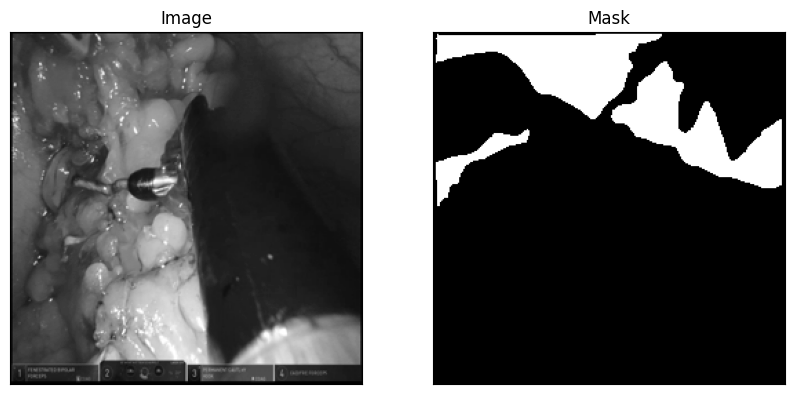

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()